# Pre-Filtering Analysis
In this notebook, we will look at the distribution of labels we have, and how many labels we'll be left with for varying filter settings.

We'll look at each type of label separately.

### Pre-requisite steps to run this notebook
1. You need to run the candidate_label_creation notebook before this notebook.

In [207]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import os
import subprocess
import matplotlib.pyplot as plt
import numpy as np
from utility import rename_cols_and_overwrite_id
from utility import run_command
from utility import kgtk_to_dataframe
from tabulate import tabulate

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Parameters
**Required**  
*work_dir*: path to work_dir that was specified in candidate_label_creation notebook. This should contain a folder called label_creation with files created by the label creation notebook which we will filter in this notebook.  
*store_dir*: path to folder containing the sqlite3.db file that we will use for our queries. We will reuse an existing file if there is one in this folder. Otherwise we will create a new one.

In [208]:
# **REQUIRED**
work_dir = "./output/wikidata_humans_v3"
store_dir = "./output/wikidata_humans_v3/temp"
item_file = "./data/wikidata_humans/claims.wikibase-item.tsv.gz"
label_file = "./data/wikidata_humans/labels.en.tsv.gz"

### Process params / set up variables

In [209]:
# Ensure paths are absolute
work_dir = os.path.abspath(work_dir)
store_dir = os.path.abspath(store_dir)
item_file = os.path.abspath(item_file)
label_file = os.path.abspath(label_file)

label_creation_dir = "{}/label_creation".format(work_dir)
    
# Create output directory
output_dir = "{}/candidate_filter".format(work_dir)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# adding some environment variables we'll be using frequently
os.environ['STORE'] = "{}/wikidata.sqlite3.db".format(store_dir)
os.environ['OUT'] = output_dir
os.environ['IN'] = label_creation_dir
os.environ["ITEM_FILE"] = item_file
os.environ['LABEL_FILE'] = label_file
os.environ['kgtk'] = "kgtk" # Need to do this for kgtk to be recognized as a command when passing it through a subprocess call

## Compute supports for each kind of label...

**AVL - string labels**

In [210]:
if not os.path.isfile("{}/candidate_labels_avl_string.tsv".format(label_creation_dir)):
    print("No string labels file found, skipping this step.")
else:
    # perform query
    command = "$kgtk query -i $IN/entity_counts_per_type.tsv -i $IN/candidate_labels_avl_string.tsv \
               -o $OUT/candidate_labels_avl_string_supports.tsv \
               --graph-cache $STORE \
               --match 'candidate: (type)-[l1 {label:prop, positives:pos, property_label:lab}]->(val), counts_per_type: (type)-[]->(count)' \
               --return 'type as type, prop as prop, lab as prop_label, val as val, pos as positives, kgtk_quantity_number_float(pos)/kgtk_quantity_number(count) as support, \"_\" as id' \
               --order-by 'kgtk_quantity_number_float(pos)/kgtk_quantity_number(count)'"
    run_command(command)
    # reformat columns to be in KGTK format
    rename_cols_and_overwrite_id("$OUT/candidate_labels_avl_string_supports", ".tsv", "type prop val", "node1 label node2")

No string labels file found, skipping this step.


**AVL - time.year labels**

In [211]:
!kgtk query -i $IN/entity_counts_per_type.tsv -i $IN/candidate_labels_avl_time.year.tsv \
-o $OUT/candidate_labels_avl_time.year_supports.tsv \
--graph-cache $STORE \
--match 'candidate: (type)-[l1 {label:prop, positives:pos, property_label:lab}]->(val), counts_per_type: (type)-[]->(count)' \
--return 'type as type, prop as prop, lab as prop_label, val as val, pos as positives, kgtk_quantity_number_float(pos)/kgtk_quantity_number(count) as support, "_" as id' \
--order-by 'kgtk_quantity_number_float(pos)/kgtk_quantity_number(count)'

In [212]:
rename_cols_and_overwrite_id("$OUT/candidate_labels_avl_time.year_supports", ".tsv", "type prop val", "node1 label node2")

**AVL - quantity labels**

In [213]:
!kgtk query -i $IN/entity_counts_per_type.tsv -i $IN/candidate_labels_avl_quantity.tsv \
-o $OUT/candidate_labels_avl_quantity_supports.tsv \
--graph-cache $STORE \
--match 'candidate: (type)-[l1 {label:prop, positives:pos, property_label:lab, si_units:si, wd_units:wd}]->(val), counts_per_type: (type)-[]->(count)' \
--return 'type as type, prop as prop, lab as prop_label, val as val, pos as positives, kgtk_quantity_number_float(pos)/kgtk_quantity_number(count) as support, si as si_units, wd as wd_units, "_" as id' \
--order-by 'kgtk_quantity_number_float(pos)/kgtk_quantity_number(count)'

In [214]:
rename_cols_and_overwrite_id("$OUT/candidate_labels_avl_quantity_supports", ".tsv", "type prop val", "node1 label node2")

**RELs**

In [215]:
!kgtk query -i $IN/entity_counts_per_type.tsv -i $IN/candidate_labels_rel_item.tsv -i $LABEL_FILE \
-o $OUT/candidate_labels_rel_item_supports.tsv \
--graph-cache $STORE \
--match 'candidate: (type)-[l1 {label:prop, positives:pos, property_label:lab}]->(val), counts_per_type: (type)-[]->(count), `'"$LABEL_FILE"'`: (val)-[:label]->(val_lab)' \
--return 'type as type, prop as prop, lab as prop_label, val as val, val_lab as val_label, pos as positives, kgtk_quantity_number_float(pos)/kgtk_quantity_number(count) as support, "_" as id' \
--order-by 'kgtk_quantity_number_float(pos)/kgtk_quantity_number(count)' \
--where 'val_lab.kgtk_lqstring_lang_suffix = "en"'

In [216]:
rename_cols_and_overwrite_id("$OUT/candidate_labels_rel_item_supports", ".tsv", "type prop val", "node1 label node2")

**RALs - non-bucketed**

In [217]:
!kgtk query -i $IN/entity_counts_per_type.tsv -i $IN/candidate_labels_ravl.tsv -i $LABEL_FILE \
-o $OUT/candidate_labels_ravl_supports.tsv \
--graph-cache $STORE \
--match 'candidate: (type1)-[l1 {label:prop1, prop2:prop2, positives:pos, prop2_label:prop2_lab, value:val, si_units:si, wd_units:wd}]->(type2), counts_per_type: (type1)-[]->(count), `'"$LABEL_FILE"'`: (type1)-[:label]->(type1_lab), `'"$LABEL_FILE"'`: (prop1)-[:label]->(prop1_lab), `'"$LABEL_FILE"'`: (type2)-[:label]->(type2_lab)' \
--return 'type1 as type1, prop1 as prop1, prop1_lab as prop1_label, type2 as type2, type2_lab as type2_label, prop2 as prop2, prop2_lab as prop2_label, val as val, pos as positives, kgtk_quantity_number_float(pos)/kgtk_quantity_number(count) as support, si as si_units, wd as wd_units, "_" as id' \
--order-by 'kgtk_quantity_number_float(pos)/kgtk_quantity_number(count)' \
--where 'prop1_lab.kgtk_lqstring_lang_suffix = "en" AND type2_lab.kgtk_lqstring_lang_suffix = "en" AND prop2_lab.kgtk_lqstring_lang_suffix = "en"'

In [218]:
rename_cols_and_overwrite_id("$OUT/candidate_labels_ravl_supports", ".tsv", "type1 prop1 type2", "node1 label node2")

**RALs - bucketed**

In [219]:
!kgtk query -i $IN/entity_counts_per_type.tsv -i $IN/candidate_labels_rail.tsv -i $LABEL_FILE\
-o $OUT/candidate_labels_rail_supports.tsv \
--graph-cache $STORE \
--match 'candidate: (type1)-[l1 {label:prop1, prop2:prop2, positives:pos, prop2_label:prop2_lab, lower_bound:lb, upper_bound:ub, si_units:si, wd_units:wd}]->(type2), counts_per_type: (type1)-[]->(count), `'"$LABEL_FILE"'`: (type1)-[:label]->(type1_lab), `'"$LABEL_FILE"'`: (prop1)-[:label]->(prop1_lab), `'"$LABEL_FILE"'`: (type2)-[:label]->(type2_lab)' \
--return 'type1 as type1, prop1 as prop1, prop1_lab as prop1_label, type2 as type2, type2_lab as type2_label, prop2 as prop2, prop2_lab as prop2_label, lb as lower_bound, ub as upper_bound, pos as positives, kgtk_quantity_number_float(pos)/kgtk_quantity_number(count) as support, si as si_units, wd as wd_units, "_" as id' \
--order-by 'kgtk_quantity_number_float(pos)/kgtk_quantity_number(count)' \
--where 'prop1_lab.kgtk_lqstring_lang_suffix = "en" AND type2_lab.kgtk_lqstring_lang_suffix = "en" AND prop2_lab.kgtk_lqstring_lang_suffix = "en"'

In [220]:
rename_cols_and_overwrite_id("$OUT/candidate_labels_rail_supports", ".tsv", "type1 prop1 type2", "node1 label node2")

**AIL - time.year**

In [221]:
!kgtk query -i $IN/entity_counts_per_type.tsv -i $IN/candidate_labels_ail_time.year.tsv \
-o $OUT/candidate_labels_ail_time.year_supports.tsv \
--graph-cache $STORE \
--match 'candidate: (type)-[l1 {label:prop, upper_bound:ub, positives:pos, property_label:lab}]->(lb), counts_per_type: (type)-[]->(count)' \
--return 'type as type, prop as prop, lab as prop_label, lb as lower_bound, ub as upper_bound, pos as positives, kgtk_quantity_number_float(pos)/kgtk_quantity_number(count) as support, "_" as id' \
--order-by 'kgtk_quantity_number_float(pos)/kgtk_quantity_number(count)'

In [222]:
rename_cols_and_overwrite_id("$OUT/candidate_labels_ail_time.year_supports", ".tsv", "type prop lower_bound", "node1 label node2")

**AIL - Quantity**

In [223]:
!kgtk query -i $IN/entity_counts_per_type.tsv -i $IN/candidate_labels_ail_quantity.tsv \
-o $OUT/candidate_labels_ail_quantity_supports.tsv \
--graph-cache $STORE \
--match 'candidate: (type)-[l1 {label:prop, si_units:si, wd_units:wd, upper_bound:ub, positives:pos, property_label:lab}]->(lb), counts_per_type: (type)-[]->(count)' \
--return 'type as type, prop as prop, lab as prop_label, si as si_units, wd as wd_units, lb as lower_bound, ub as upper_bound, pos as positives, kgtk_quantity_number_float(pos)/kgtk_quantity_number(count) as support, "_" as id' \
--order-by 'kgtk_quantity_number_float(pos)/kgtk_quantity_number(count)'

In [224]:
rename_cols_and_overwrite_id("$OUT/candidate_labels_ail_quantity_supports", ".tsv", "type prop lower_bound", "node1 label node2")

In [225]:
avl_string_supports_file = "{}/candidate_labels_avl_string_supports.tsv".format(output_dir)
avl_year_supports_file = "{}/candidate_labels_avl_time.year_supports.tsv".format(output_dir)
avl_quantity_supports_file = "{}/candidate_labels_avl_quantity_supports.tsv".format(output_dir)
rel_supports_file = "{}/candidate_labels_rel_item_supports.tsv".format(output_dir)
ral_supports_file = "{}/candidate_labels_ravl_supports.tsv".format(output_dir)
rail_supports_file = "{}/candidate_labels_rail_supports.tsv".format(output_dir)
ail_year_supports_file = "{}/candidate_labels_ail_time.year_supports.tsv".format(output_dir)
ail_quantity_supports_file = "{}/candidate_labels_ail_quantity_supports.tsv".format(output_dir)

## Investigate distribution of supports as well as number of labels for various filter bounds

In [226]:
def print_num_labels_for_filter_bounds(support_file, ent_type=None, lbounds=[.1], ubounds=[.9],
                                       custom_bins=None, logscale=False, entity_to_label_id_df=None,
                                       inbound_file=None):
    df = pd.read_csv(support_file, delimiter = '\t')
    if ent_type is not None:
        df = df.loc[df.loc[:,"node1"] == ent_type]
    
    supports = df.loc[:,"support"]
    
    if custom_bins is not None:
        bins = custom_bins
    else:
        bins = np.arange(0,1.01,.02)
    plt.hist(supports, bins = bins)
    plt.title("Distribution of Label Supports")
    plt.xlabel("Label Support")
    plt.ylabel("Number of Labels")
    if logscale:
        plt.yscale('log')
    plt.show()
    
    if ent_type is not None:
        print("Looking at labels for type: {}".format(ent_type))
        num_ents = int(df.loc[df.index[0], "positives"] / df.loc[df.index[0], "support"])
        print("Num ents of this type: {}".format(num_ents))
    print("Total labels: {}".format(len(supports)))
    if entity_to_label_id_df is not None:
        print("Total num ents these labels are applicable to: {}".format(len(set(entity_to_label_id_df.loc[:,"entity"]))))
    
    headers=["lower bounds:"]
    for lbound in lbounds:
        headers.append(lbound)
    for ubound in ubounds:
        print("\nFor upper bound = {}...".format(ubound))
        
        count_inbound_row=["# labels in bounds:"]
        if "prop2" in df.columns:
            count_1_props_row=["# unique 1st props:"]
            count_2_props_row=["# unique 2 prop paths:"]
        else:
            count_1_props_row=["# unique props:"]
        if entity_to_label_id_df is not None:
            applic_ents=["# applicable ents:"]
            mean_per_ent=["avg #labels/applic-ent:"]
            std_per_ent=["std #labels/applic-ent:"]
            min_per_ent=["min #labels/applic-ent:"]
            pct25_per_ent=["25% #labels/applic-ent:"]
            pct50_per_ent=["50% #labels/applic-ent:"]
            pct75_per_ent=["75% #labels/applic-ent:"]
            max_per_ent=["max #labels/applic-ent:"]
        
        for lbound in lbounds:
            inbound_mask = ((supports >= lbound) & (supports <= ubound))
            inbound_df = df.loc[inbound_mask]
            
            if lbound == min(lbounds) and inbound_file is not None:
                inbound_df.to_csv(path_or_buf = inbound_file, index = False, sep = '\t')
            
            count_inbound_row.append(len(inbound_df))
            
            inbound_1_prop_counts = inbound_df.groupby(["label"]).agg("count")
            count_1_props_row.append(len(inbound_1_prop_counts))
            if "prop2" in df.columns:
                inbound_2_prop_counts = inbound_df.groupby(["label","prop2"]).agg("count")
                count_2_props_row.append(len(inbound_2_prop_counts))
            
            if entity_to_label_id_df is not None:
                inbound_ids = set(inbound_df.loc[:,"id"])
                applic_ent_to_label = entity_to_label_id_df.loc[entity_to_label_id_df.loc[:,"support_file_label_id"].isin(inbound_ids),:]
                ent_to_label_count_df = applic_ent_to_label.groupby(["entity"]).agg("count")
                stats = ent_to_label_count_df.describe()
                applic_ents.append(stats.loc["count","support_file_label_id"])
                mean_per_ent.append(stats.loc["mean","support_file_label_id"])
                std_per_ent.append(stats.loc["std","support_file_label_id"])
                min_per_ent.append(stats.loc["min","support_file_label_id"])
                pct25_per_ent.append(stats.loc["25%","support_file_label_id"])
                pct50_per_ent.append(stats.loc["50%","support_file_label_id"])
                pct75_per_ent.append(stats.loc["75%","support_file_label_id"])
                max_per_ent.append(stats.loc["max","support_file_label_id"])
        rows=[count_inbound_row,
              count_1_props_row]
        if "prop2" in df.columns:
            rows.append(count_2_props_row)
        if entity_to_label_id_df is not None:
            rows.extend([applic_ents,
                          mean_per_ent,
                          std_per_ent,
                          min_per_ent,
                          pct25_per_ent,
                          pct50_per_ent,
                          pct75_per_ent,
                          max_per_ent])
        print(tabulate(rows, headers=headers))

**AVL - string labels**

In [227]:
if not os.path.isfile(avl_string_supports_file):
    print("No string labels file found, skipping this step.")
else:
    print_num_labels_for_filter_bounds(avl_string_supports_file, ent_type='Q5', lbounds=[.1,.03,.01])

No string labels file found, skipping this step.


**AVL - time.year labels**

In [228]:
os.environ["SUP_FILE"] = avl_year_supports_file
os.environ["TYPE"] = "Q5"
!kgtk query -i $SUP_FILE -o $OUT/temp_supp_file.tsv\
--graph-cache $STORE \
--match 'support: (t:`'"$TYPE"'`)-[l2 {label:p}]->(val)' \
--return 'distinct t as node1, p as label, val as node2, l2 as id'

In [229]:
res = !kgtk query -i $OUT/temp_supp_file.tsv -i $IN/entity_attribute_labels_time.year.tsv \
--graph-cache $STORE \
--match 'entity: (t:`'"$TYPE"'`)-[l1 {label:p, property_label:lab, entity:e}]->(val), supp: ()-[l2 {label:p}]->(val)' \
--return 'distinct e as entity, l2 as support_file_label_id' \
--order-by 'e'
res_df = kgtk_to_dataframe(res)

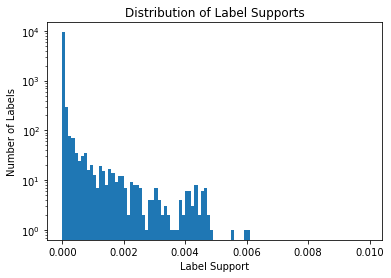

Looking at labels for type: Q5
Num ents of this type: 7958973
Total labels: 10301
Total num ents these labels are applicable to: 4419871

For upper bound = 0.9...
lower bounds:              0.1    0.03    0.01         0.003         0.001         0.0003         0.0001
-----------------------  -----  ------  ------  ------------  ------------  -------------  -------------
# labels in bounds:          0       0       0  71            249           479            854
# unique props:              0       0       0   1              2             3              3
# applicable ents:           0       0       0   2.29076e+06    3.5566e+06    4.03031e+06    4.26303e+06
avg #labels/applic-ent:    nan     nan     nan   1.00371        1.34974       1.45008        1.47916
std #labels/applic-ent:    nan     nan     nan   0.0612166      0.482819      0.507875       0.521426
min #labels/applic-ent:    nan     nan     nan   1              1             1              1
25% #labels/applic-ent:    nan    

In [230]:
inbound_file="{}/inbound_label_analysis_Q5_avl_year.tsv".format(output_dir)

print_num_labels_for_filter_bounds(avl_year_supports_file, ent_type='Q5',
                                   lbounds=[.1,.03,.01,.003, .001,.0003,.0001],
                                   custom_bins=np.arange(0,.01,.0001), logscale=True,
                                   entity_to_label_id_df=res_df,
                                   inbound_file=inbound_file)


**AVL - quantity labels**

In [231]:
os.environ["SUP_FILE"] = avl_quantity_supports_file
os.environ["TYPE"] = "Q5"
!kgtk query -i $SUP_FILE -o $OUT/temp_supp_file.tsv\
--graph-cache $STORE \
--match 'support: (t:`'"$TYPE"'`)-[l2 {label:p, si_units:si, wd_units:wd}]->(val)' \
--return 'distinct t as node1, p as label, si as si_units, wd as wd_units, val as node2, l2 as id'

In [232]:
res = !kgtk query -i $OUT/temp_supp_file.tsv -i $IN/entity_attribute_labels_quantity.tsv \
--graph-cache $STORE \
--match 'entity: (t:`'"$TYPE"'`)-[l1 {label:p, property_label:lab, entity:e, si_units:si, wd_units:wd}]->(val), supp: ()-[l2 {label:p, si_units:si, wd_units:wd}]->(val)' \
--return 'distinct e as entity, l2 as support_file_label_id' \
--order-by 'e'
res_df = kgtk_to_dataframe(res)

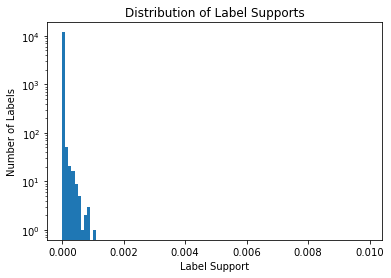

Looking at labels for type: Q5
Num ents of this type: 7958973
Total labels: 11971
Total num ents these labels are applicable to: 216994

For upper bound = 0.9...
lower bounds:              0.1    0.03    0.01    0.003    0.001         0.0003         0.0001
-----------------------  -----  ------  ------  -------  -------  -------------  -------------
# labels in bounds:          0       0       0        0        1      37            108
# unique props:              0       0       0        0        1       3              7
# applicable ents:           0       0       0        0     8646  112360         164780
avg #labels/applic-ent:    nan     nan     nan      nan        1       1.27956        1.46241
std #labels/applic-ent:    nan     nan     nan      nan        0       0.460857       0.541989
min #labels/applic-ent:    nan     nan     nan      nan        1       1              1
25% #labels/applic-ent:    nan     nan     nan      nan        1       1              1
50% #labels/applic-

In [233]:
inbound_file="{}/inbound_label_analysis_Q5_avl_quantity.tsv".format(output_dir)

print_num_labels_for_filter_bounds(avl_quantity_supports_file, ent_type='Q5',
                                   lbounds=[.1,.03,.01,.003, .001,.0003,.0001],
                                   custom_bins=np.arange(0,.01,.0001), logscale=True,
                                   entity_to_label_id_df=res_df,
                                   inbound_file=inbound_file)

**AIL - time.year**

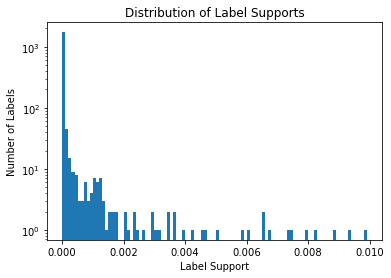

Looking at labels for type: Q5
Num ents of this type: 7958973
Total labels: 1915

For upper bound = 0.9...
lower bounds:          0.1    0.03    0.01    0.003    0.001    0.0003    0.0001
-------------------  -----  ------  ------  -------  -------  --------  --------
# labels in bounds:      0       7      25       48       87       123       183
# unique props:          0       1       2        3        3         4         5


In [234]:
inbound_file="{}/inbound_label_analysis_Q5_ail_year.tsv".format(output_dir)
    
print_num_labels_for_filter_bounds(ail_year_supports_file, ent_type='Q5',
                                   lbounds=[.1,.03,.01,.003, .001,.0003,.0001],
                                   custom_bins=np.arange(0,.01,.0001), logscale=True,
                                   inbound_file=inbound_file)

**AIL - Quantity**

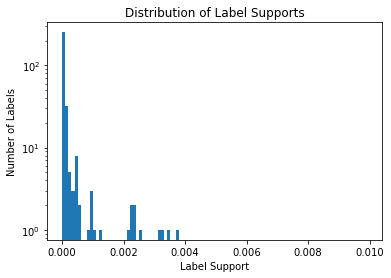

Looking at labels for type: Q5
Num ents of this type: 7958973
Total labels: 318

For upper bound = 0.9...
lower bounds:          0.1    0.03    0.01    0.003    0.001    0.0003    0.0001
-------------------  -----  ------  ------  -------  -------  --------  --------
# labels in bounds:      0       0       0        4       12        29        66
# unique props:          0       0       0        1        3         4        12


In [235]:
inbound_file="{}/inbound_label_analysis_Q5_ail_quantity.tsv".format(output_dir)

print_num_labels_for_filter_bounds(ail_quantity_supports_file, ent_type='Q5',
                                   lbounds=[.1,.03,.01,.003, .001,.0003,.0001],
                                   custom_bins=np.arange(0,.01,.0001), logscale=True,
                                   inbound_file=inbound_file)

**RELs**

In [236]:
os.environ["SUP_FILE"] = rel_supports_file
os.environ["TYPE"] = "Q5"
!kgtk query -i $SUP_FILE -o $OUT/temp_supp_file.tsv\
--graph-cache $STORE \
--match 'support: (t:`'"$TYPE"'`)-[l2 {label:p}]->(val)' \
--return 'distinct t as node1, p as label, val as node2, l2 as id'

In [237]:
res = !kgtk query -i $OUT/temp_supp_file.tsv -i $ITEM_FILE -i $IN/type_mapping.tsv \
--graph-cache $STORE \
--match 'item: (e)-[l1 {label:p}]->(val), type_mapping: (e)-[]->(t:`'"$TYPE"'`), supp: ()-[l2 {label:p}]->(val)' \
--return 'distinct e as entity, l2 as support_file_label_id' \
--order-by 'e'
res_df = kgtk_to_dataframe(res)

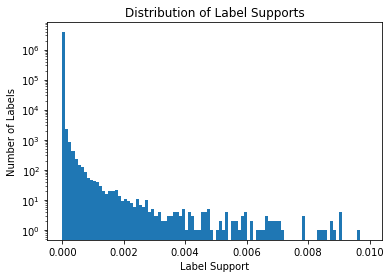

Looking at labels for type: Q5
Num ents of this type: 7958973
Total labels: 3804856
Total num ents these labels are applicable to: 7958973

For upper bound = 0.9...
lower bounds:                  0.1          0.03          0.01          0.003          0.001          0.0003
-----------------------  ---------  ------------  ------------  -------------  -------------  --------------
# labels in bounds:      3          10            33            141            449            1552
# unique props:          2           4            10             24             42              60
# applicable ents:       7.392e+06   7.41170e+06   7.45763e+06    7.54492e+06    7.61565e+06     7.70788e+06
avg #labels/applic-ent:  1.03489     1.3341        1.70622        2.28887        2.79873         3.34169
std #labels/applic-ent:  0.183512    0.595948      1.02313        1.48566        1.87746         2.33968
min #labels/applic-ent:  1           1             1              1              1               1
2

In [238]:
inbound_file="{}/inbound_label_analysis_Q5_rel.tsv".format(output_dir)

print_num_labels_for_filter_bounds(rel_supports_file, ent_type='Q5',
                                   lbounds=[.1,.03,.01,.003, .001,.0003],
                                   custom_bins=np.arange(0,.01,.0001), logscale=True,
                                   entity_to_label_id_df=res_df,
                                   inbound_file=inbound_file)

**RALs - non-bucketed**

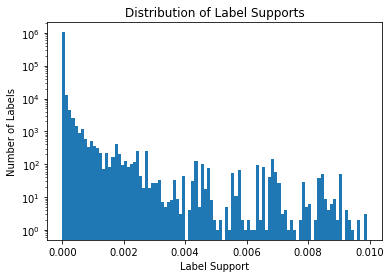

Looking at labels for type: Q5
Num ents of this type: 7958973
Total labels: 1073927

For upper bound = 0.9...
lower bounds:             0.1    0.03    0.01    0.003    0.001    0.0003    0.0001
----------------------  -----  ------  ------  -------  -------  --------  --------
# labels in bounds:        10     348     873     2268     5460     13051     30054
# unique 1st props:         1       2       3        9       28        43        61
# unique 2 prop paths:      5      30      40       84      188       343       519


In [239]:
inbound_file="{}/inbound_label_analysis_Q5_ral.tsv".format(output_dir)

print_num_labels_for_filter_bounds(ral_supports_file, ent_type='Q5',
                                   lbounds=[.1,.03,.01,.003, .001,.0003,.0001],
                                   custom_bins=np.arange(0,.01,.0001), logscale=True,
                                   inbound_file=inbound_file)

**RALs - bucketed**

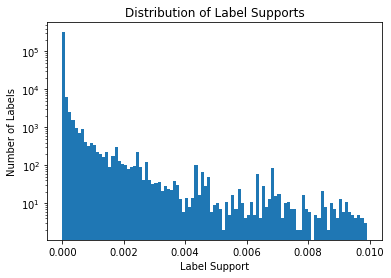

Looking at labels for type: Q5
Num ents of this type: 7958973
Total labels: 339242

For upper bound = 0.9...
lower bounds:             0.1    0.03    0.01    0.003    0.001    0.0003    0.0001
----------------------  -----  ------  ------  -------  -------  --------  --------
# labels in bounds:        31     397     871     1984     4884     10149     19177
# unique 1st props:         1       2       8       19       37        52        75
# unique 2 prop paths:     14      34      56      124      242       408       591


In [240]:
inbound_file="{}/inbound_label_analysis_Q5_rail.tsv".format(output_dir)

print_num_labels_for_filter_bounds(rail_supports_file, ent_type='Q5',
                                   lbounds=[.1,.03,.01,.003, .001,.0003,.0001],
                                   custom_bins=np.arange(0,.01,.0001), logscale=True,
                                   inbound_file=inbound_file)